In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json

In [49]:
# load dataset
df = pd.read_csv("datasets/airline_arrival_delays/AirlineData.csv")

In [51]:
old_columns = df.columns

# convert column names to Pascal case
for old_column in old_columns:
    new_column = "".join([segment.lower().capitalize() for segment in old_column.split("_")])
    df[new_column] = df[old_column]
 
df = df.drop(old_columns, axis=1)

In [53]:
# we first ignore the canceled flights because we only predict the flights are late or not
df = df[df["Cancelled"] == False]
# because we only classify whether the flight is late or not, so we have to drop the other delay columns
df = df.drop(["CarrierDelay",
              "WeatherDelay",
              "NasDelay",
              "SecurityDelay",
              "LateAircraftDelay",
              "Cancelled",
              "CancellationCode"], axis=1)

df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# besides, there are no reason to keep ArrTime and ArrDelay anymore, because they could potentially harm the model's result
df = df.drop(["ArrTime", "ArrDelay"], axis=1)

## Exploratory Data Analysis

In [54]:
# after filtering unnecessary columns, we now have only 21 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600418 entries, 0 to 607345
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               600418 non-null  int64  
 1   Month              600418 non-null  int64  
 2   DayOfMonth         600418 non-null  int64  
 3   DayOfWeek          600418 non-null  int64  
 4   OpUniqueCarrier    600418 non-null  object 
 5   TailNum            600418 non-null  object 
 6   OpCarrierFlNum     600418 non-null  int64  
 7   Origin             600418 non-null  object 
 8   Dest               600418 non-null  object 
 9   CrsDepTime         600418 non-null  int64  
 10  DepTime            600418 non-null  float64
 11  DepDelay           600418 non-null  float64
 12  TaxiOut            600418 non-null  float64
 13  TaxiIn             600271 non-null  float64
 14  CrsArrTime         600418 non-null  int64  
 15  Diverted           600418 non-null  float64
 16  Cr

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,600418.0,2020.000000,0.000000,2020.0,2020.0,2020.0,2020.0,2020.0
Month,600418.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
DayOfMonth,600418.0,16.024173,9.015827,1.0,8.0,16.0,24.0,31.0
DayOfWeek,600418.0,3.947588,1.911872,1.0,2.0,4.0,5.0,7.0
OpCarrierFlNum,600418.0,2618.095004,1821.732919,1.0,1067.0,2171.0,4105.0,6860.0
CrsDepTime,600418.0,1329.142934,488.895793,2.0,915.0,1322.0,1734.0,2359.0
DepTime,600418.0,1331.491558,497.082638,1.0,919.0,1326.0,1739.0,2400.0
DepDelay,600418.0,6.167097,43.133126,-58.0,-6.0,-3.0,2.0,2489.0
TaxiOut,600418.0,17.356115,9.621951,1.0,11.0,15.0,20.0,189.0
TaxiIn,600271.0,7.503138,5.670835,1.0,4.0,6.0,9.0,146.0


In [56]:
df.describe(include="O")

,OpUniqueCarrier,TailNum,Origin,Dest
count,600418,600418,600418,600418
unique,17,5443,351,350
top,WN,N488HA,ATL,ATL
freq,107849,333,32102,32105


## All columns and their description

1. Year: ~~ 1987-2008 ---- Year doesn't tell any story.
2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. DepTime: ~~ actual departure time (local, hhmm)
6. CRSDepTime: ~~ scheduled departure time (local, hhmm)
7. ArrTime: ~~ actual arrival time (local, hhmm)
8. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
9. UniqueCarrier: ~~ unique carrier code
10. FlightNum: ~~ flight number
11. TailNum: ~~ plane tail number
12. ActualElapsedTime: ~~ in minutes
13. CRSElapsedTime: ~~ in minutes
14. AirTime: ~~ in minutes
15. ArrDelay: ~~ arrival delay, in minutes
16. DepDelay: ~~ departure delay, in minutes
17. Origin: ~~ origin IATA airport code
18. Dest: ~~ destination IATA airport code
19. Distance: ~~ in miles
20. TaxiIn: ~~ taxi in time, in minutes
21. TaxiOut: ~~ taxi out time in minutes
22. Cancelled: ~~ was the flight cancelled?
23. CancellationCode: ~~ reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted: ~~ 1 = yes, 0 = no
25. CarrierDelay: ~~ in minutes
26. WeatherDelay: ~~ in minutes
27. NASDelay: ~~ in minutes
28. SecurityDelay: ~~ in minutes
29. LateAircraftDelay: ~~ in minutes

In [58]:
df.head(5).T

,0,1,4,6,7
Year,2020,2020,2020,2020,2020
Month,1,1,1,1,1
DayOfMonth,17,17,17,17,17
DayOfWeek,5,5,5,5,5
OpUniqueCarrier,WN,WN,WN,WN,WN
TailNum,N7736A,N961WN,N8525S,N952WN,N8646B
OpCarrierFlNum,458,1469,1744,528,1041
Origin,LAS,LAS,LAS,LAS,LAS
Dest,MDW,MDW,MDW,MKE,MKE
CrsDepTime,845,550,740,1920,920


In [59]:
print(f"Total rows: {len(df)}")

Total rows: 600418


### Check missing values

In [83]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Year                    0
Month                   0
DayOfMonth              0
DayOfWeek               0
OpUniqueCarrier         0
TailNum                 0
OpCarrierFlNum          0
Origin                  0
Dest                    0
CrsDepTime              0
DepTime                 0
DepDelay                0
TaxiOut                 0
TaxiIn                147
CrsArrTime              0
Diverted                0
CrsElapsedTime          0
ActualElapsedTime    1150
AirTime              1150
Flights                 0
Distance                0
IsLate                  0
dtype: int64

In [79]:
# check rows having none ActualElapsedTime have AirTime? Answer: No, either
ActualElapsedTime_missing_index = list(df[df["ActualElapsedTime"].isnull() == True].index)
AirTime_missing_index = list(df[df["AirTime"].isnull() == True].index)
                                       
len(list(set(ActualElapsedTime_missing_index) - set(AirTime_missing_index)))

0

In [91]:
total_drop = nan_summary.values.sum() - nan_summary["AirTime"]
print(f"We only drop {total_drop / len(df) * 100}% of dataset")

# the missing value is not really significant => drop all missing vlaue
df = df.dropna()

We only drop 0.2160161753978062% of dataset


### Heatmap visualization

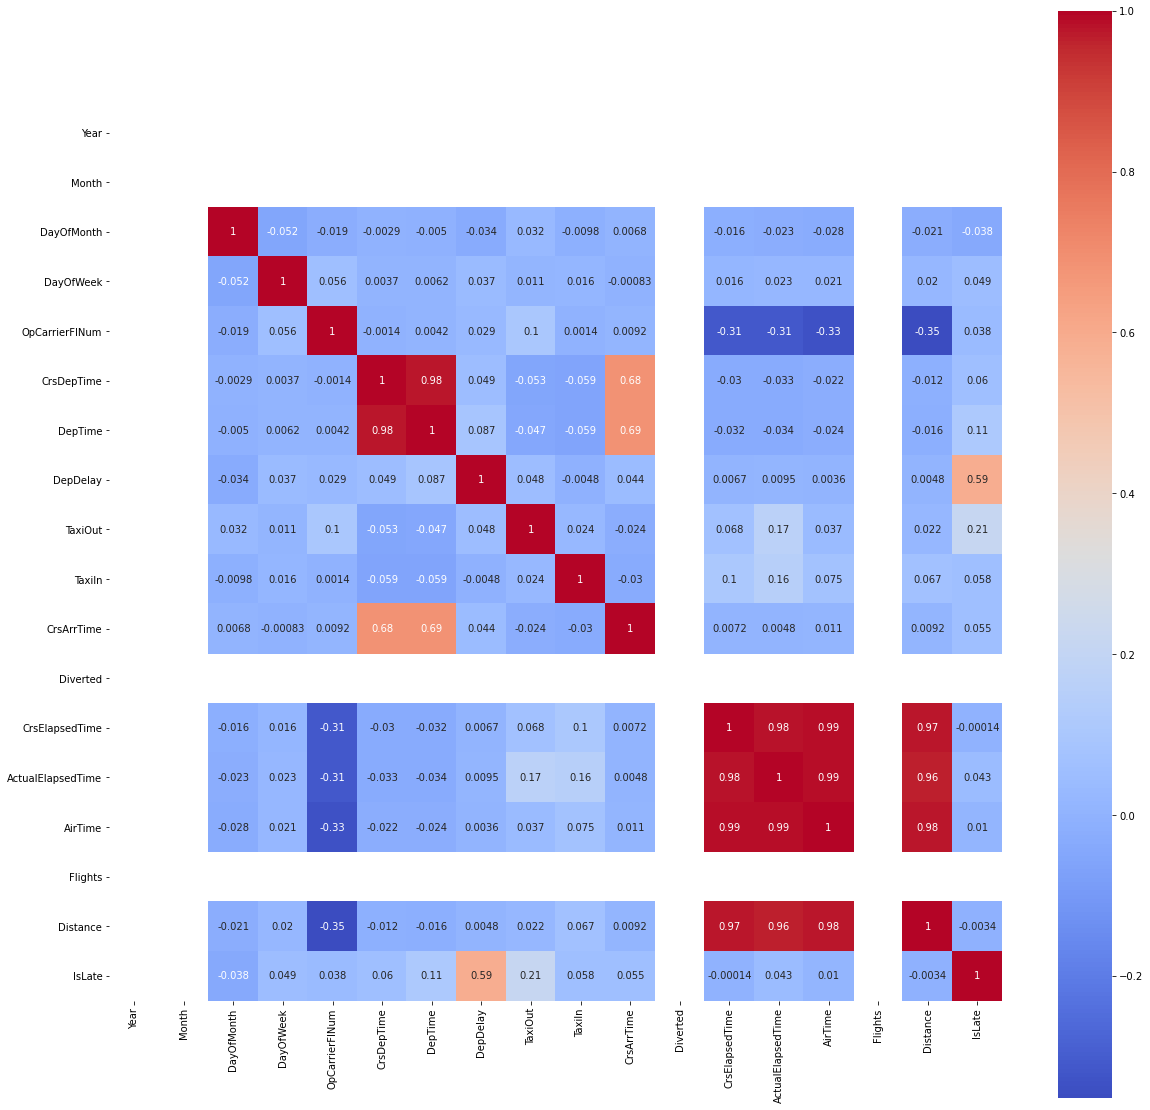

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

List all numerical features (beware time hhmm)

#### CrsDepTime

<AxesSubplot:xlabel='IsLate', ylabel='DepTime'>

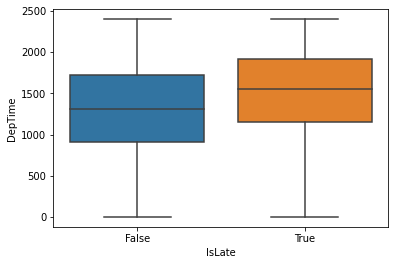

In [98]:
sns.boxplot(data=df, x="IsLate", y="DepTime")

In [97]:
df.DepTime

0          909.0
1          552.0
4          739.0
6         1921.0
7          933.0
           ...  
607341     554.0
607342     633.0
607343     657.0
607344     705.0
607345     628.0
Name: DepTime, Length: 599268, dtype: float64

### Feature engineering
- Vacation, holiday, last year
